#CS 614 Drexel University

**Shawn Oyer**

**9/3/2024**

##Processing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
nbdir = "/content/gdrive/MyDrive/CS_614/Project2"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/CS_614/Project2/

/content/gdrive/MyDrive/CS_614/Project2


In [ ]:
!pip install openai tiktoken fpdf2 pandas
!pip install python-dotenv
!pip install contractions
!pip install nltk
!pip install selenium
!pip install transformers datasets
!pip install torch
!pip install rouge_score

In [ ]:
import os
import tiktoken
import numpy as np
import pandas as pd
from typing import Any
from dotenv import load_dotenv
from string import ascii_lowercase
import multiprocessing
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from transformers import T5ForConditionalGeneration, T5Tokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from datasets import load_metric, Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

load_dotenv()

%matplotlib inline

cores = multiprocessing.cpu_count()
print(f"There are {cores} cores in the CPU")

There are 12 cores in the CPU


In [ ]:
# Read in .csv file

# Specify the path
file_path = './Hotel_Reviews.csv'

# Try reading the CSV with a different encoding
try:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp1252')

# Display the DataFrame to see full review text
df.head(10)


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968
5,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,Poland,Backyard of the hotel is total mess shouldn t...,17,1403,Good restaurant with modern design great chil...,20,1,6.7,"[' Leisure trip ', ' Group ', ' Duplex Double ...",10 days,52.360576,4.915968
6,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/2017,7.7,Hotel Arena,United Kingdom,Cleaner did not change our sheet and duvet ev...,33,1403,The room is spacious and bright The hotel is ...,18,6,4.6,"[' Leisure trip ', ' Group ', ' Duplex Twin Ro...",17 days,52.360576,4.915968
7,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/2017,7.7,Hotel Arena,United Kingdom,Apart from the price for the brekfast Everyth...,11,1403,Good location Set in a lovely park friendly s...,19,1,10.0,"[' Leisure trip ', ' Couple ', ' Duplex Double...",17 days,52.360576,4.915968
8,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/9/2017,7.7,Hotel Arena,Belgium,Even though the pictures show very clean room...,34,1403,No Positive,0,3,6.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",25 days,52.360576,4.915968
9,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/8/2017,7.7,Hotel Arena,Norway,The aircondition makes so much noise and its ...,15,1403,The room was big enough and the bed is good T...,50,1,7.9,"[' Leisure trip ', ' Couple ', ' Large King Ro...",26 days,52.360576,4.915968


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

##Testing Examples

In [ ]:
# Testing Example where user is prompted to include two reviews of a hotel, then the model will generate a combined summary for both reviews.

# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

def generate_summary(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Generate summary
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=150,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True  # Stop early if the summary is complete
    )

    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Prompt user for input reviews
print("Please enter two reviews for summarization:")

# Input reviews from user
review1 = input("Enter the first review: ")
review2 = input("Enter the second review: ")

# Combine the reviews into a single text
combined_reviews = review1 + " " + review2

# Generate summary for the combined reviews
combined_summary = generate_summary(combined_reviews)

# Display the results
print("\nGenerated Summary for Combined Reviews:")
print(f"Original Review 1: {review1}")
print(f"Original Review 2: {review2}")
print(f"Combined Summary: {combined_summary}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Please enter two reviews for summarization:
Enter the first review: bed was extremely comfy and the staff where well spoken they also gave us all the help with easiest way to city centre and all the relevant transportation tickets and unique locations to visit will definitely be returning as this city is beautiful and the people are so friendly transportation was a bit of a pain but on route to your destination there is amazing views at every corner
Enter the second review: the staff were so friendly and helpful plus the bar restaurant area is beautiful located in its own park and the old building is simply stunning little bit on the pricey side

Generated Summary for Combined Reviews:
Original Review 1: bed was extremely comfy and the staff where well spoken they also gave us all the help with easiest way to city centre and all the relevant transportation tickets and unique locations to visit will definitely be returning as this city is beautiful and the people are so friendly transpo

In [ ]:
# Testing Example where user is prompted to include two reviews of a hotel, then the model will generate a combined summary for both reviews.

# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

def generate_summary(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Generate summary
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=150,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True  # Stop early if the summary is complete
    )

    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Prompt user for input reviews
print("Please enter two reviews for summarization:")

# Input reviews from user
review1 = input("Enter the first review: ")
review2 = input("Enter the second review: ")

# Combine the reviews into a single text
combined_reviews = review1 + " " + review2

# Generate summary for the combined reviews
combined_summary = generate_summary(combined_reviews)

# Display the results
print("\nGenerated Summary for Combined Reviews:")
print(f"Original Review 1: {review1}")
print(f"Original Review 2: {review2}")
print(f"Combined Summary: {combined_summary}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Please enter two reviews for summarization:
Enter the first review: The hotel had all of the intricate artwork displayed and breakfast was extroardinary and priced reasonably.. The staff were super helpful.
Enter the second review: The hotel was fantastic! It was in a perfect location near the city centre.

Generated Summary for Combined Reviews:
Original Review 1: The hotel had all of the intricate artwork displayed and breakfast was extroardinary and priced reasonably.. The staff were super helpful.
Original Review 2: The hotel was fantastic! It was in a perfect location near the city centre.
Combined Summary: The staff were super helpful. The hotel was in perfect location near the city centre. The hotel had all of the intricate artwork displayed and breakfast was extroardinary and priced reasonably.. The staff were super helpful.The hotel was fantastic!


##EDA

In [ ]:
# Summary statistics for numerical features
print(df.describe())

# Summary statistics for categorical features
print(df.describe(include=['object']))

       Additional_Number_of_Scoring  Average_Score  \
count                 515738.000000  515738.000000   
mean                     498.081836       8.397487   
std                      500.538467       0.548048   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      341.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                           

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
Cleaned_Positive_Review                          0
Cleaned_Negative_Review                          0
dtype: int64


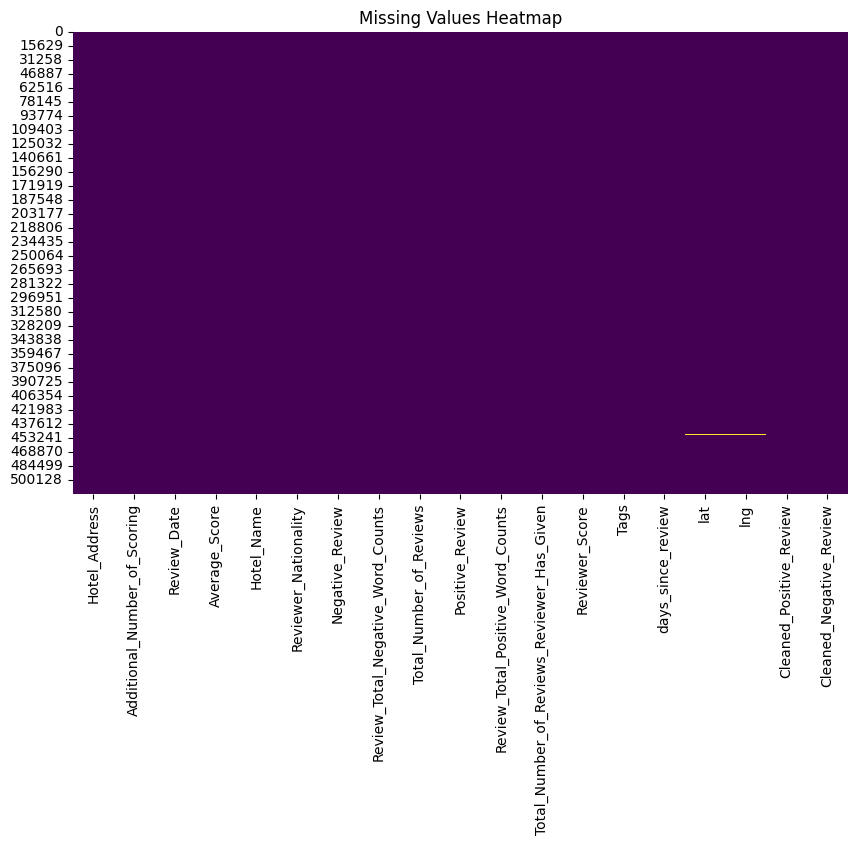

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Visualize missing values using a heatmap (requires seaborn)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

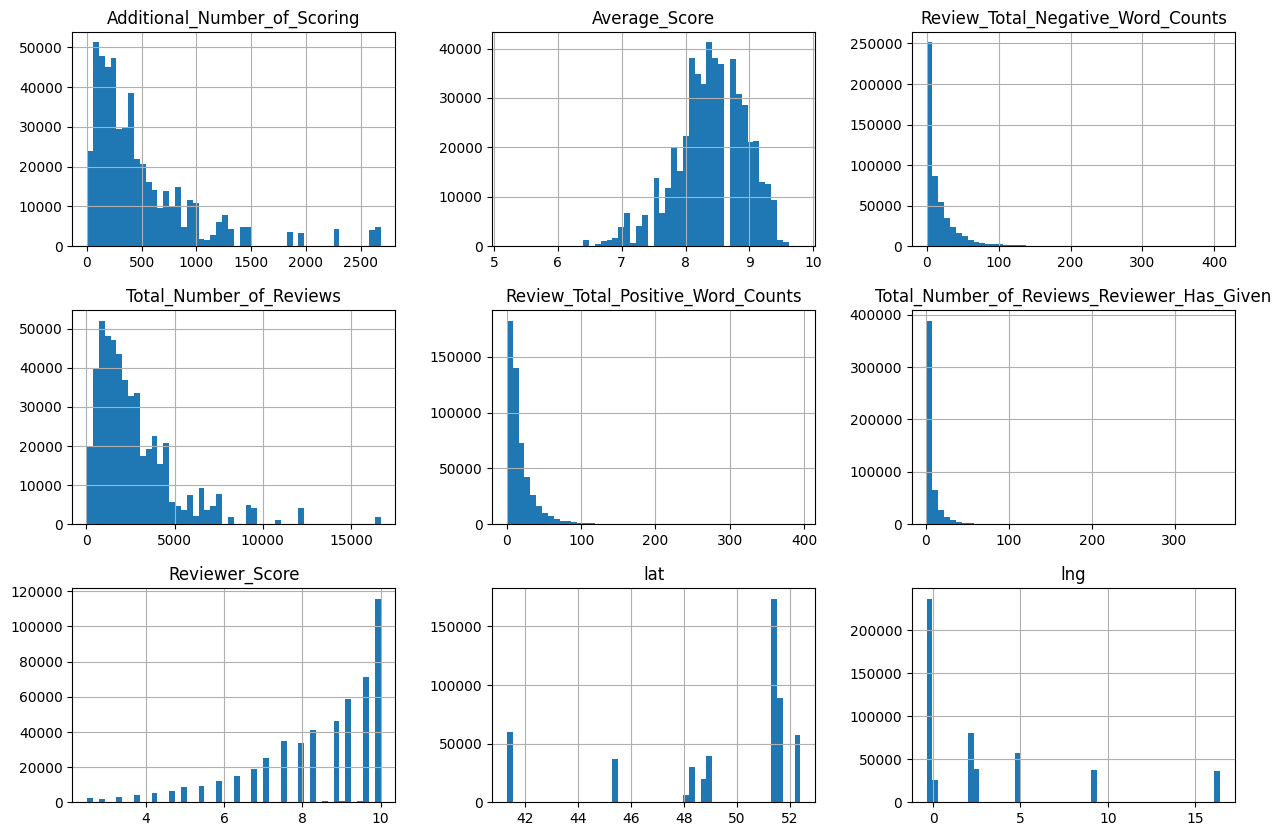

In [ ]:
# Histograms of numerical features
df.hist(bins=50, figsize=(15, 10))
plt.show()

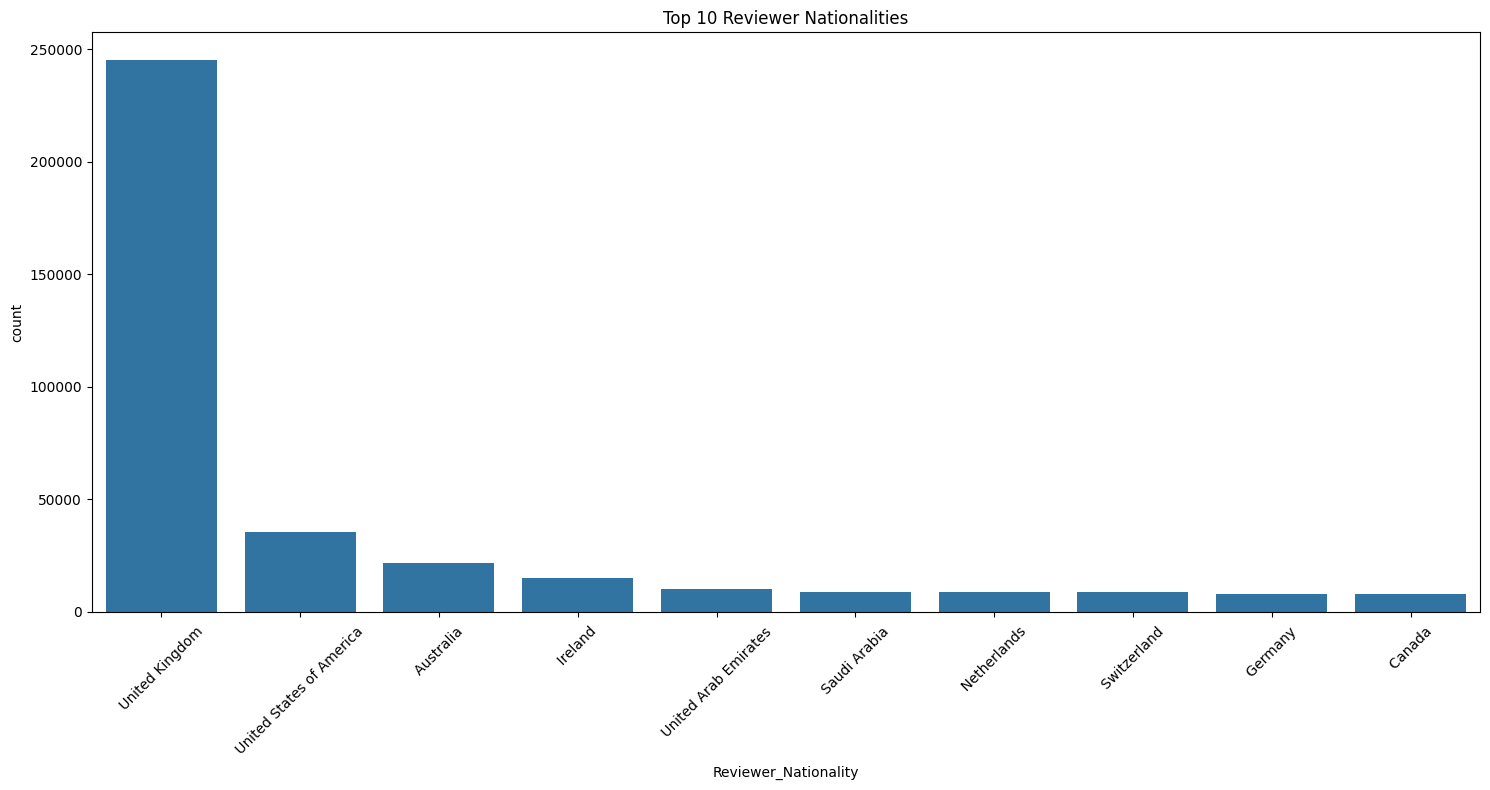

In [ ]:
top_n = 10  # Number of top categories to display
top_categories = df['Reviewer_Nationality'].value_counts().nlargest(top_n).index

plt.figure(figsize=(15, 8))
sns.countplot(data=df[df['Reviewer_Nationality'].isin(top_categories)], x='Reviewer_Nationality', order=top_categories)
plt.title(f'Top {top_n} Reviewer Nationalities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-57-aeb378da3f5a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative, y='Hotel_Name', x='Review_Total_Negative_Word_Counts', palette='coolwarm')


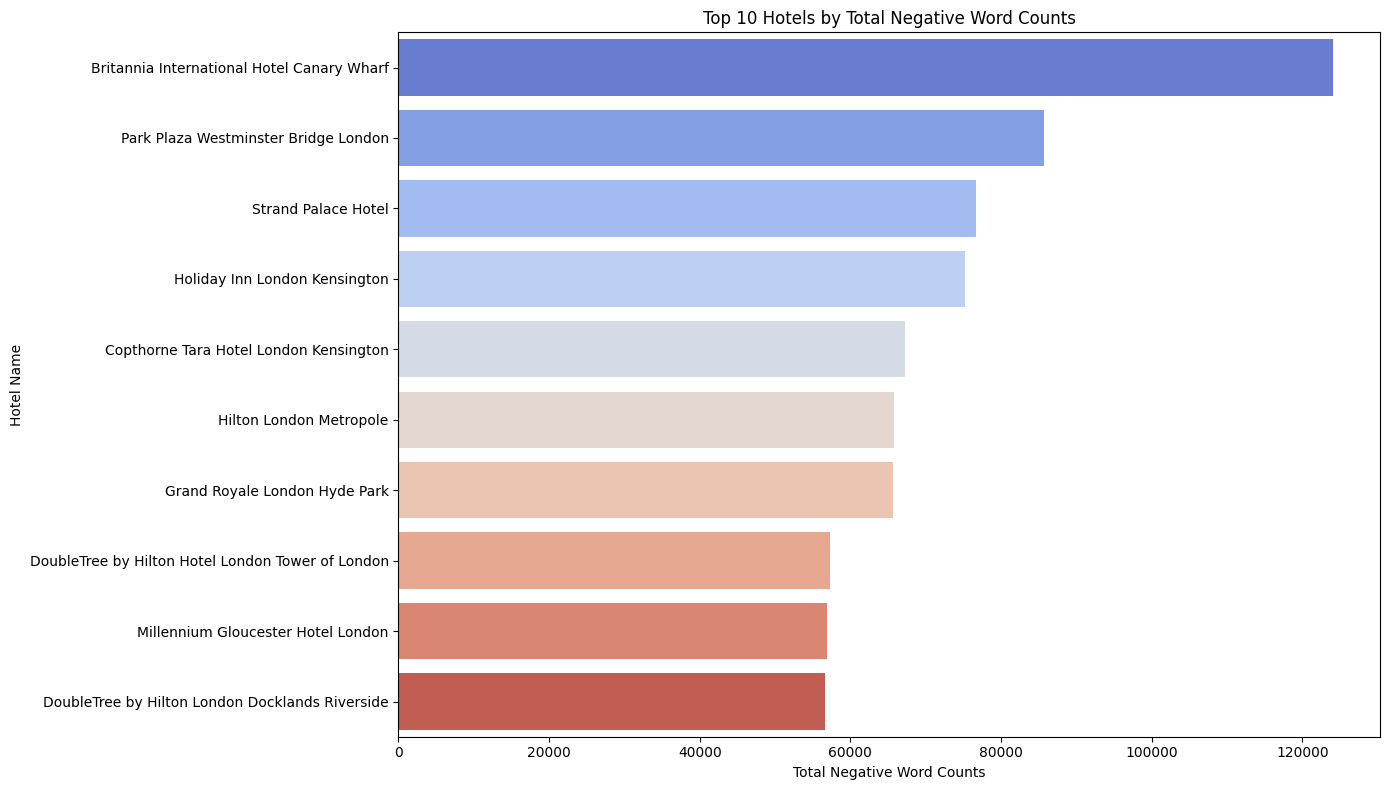

<ipython-input-57-aeb378da3f5a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive, y='Hotel_Name', x='Review_Total_Positive_Word_Counts', palette='coolwarm')


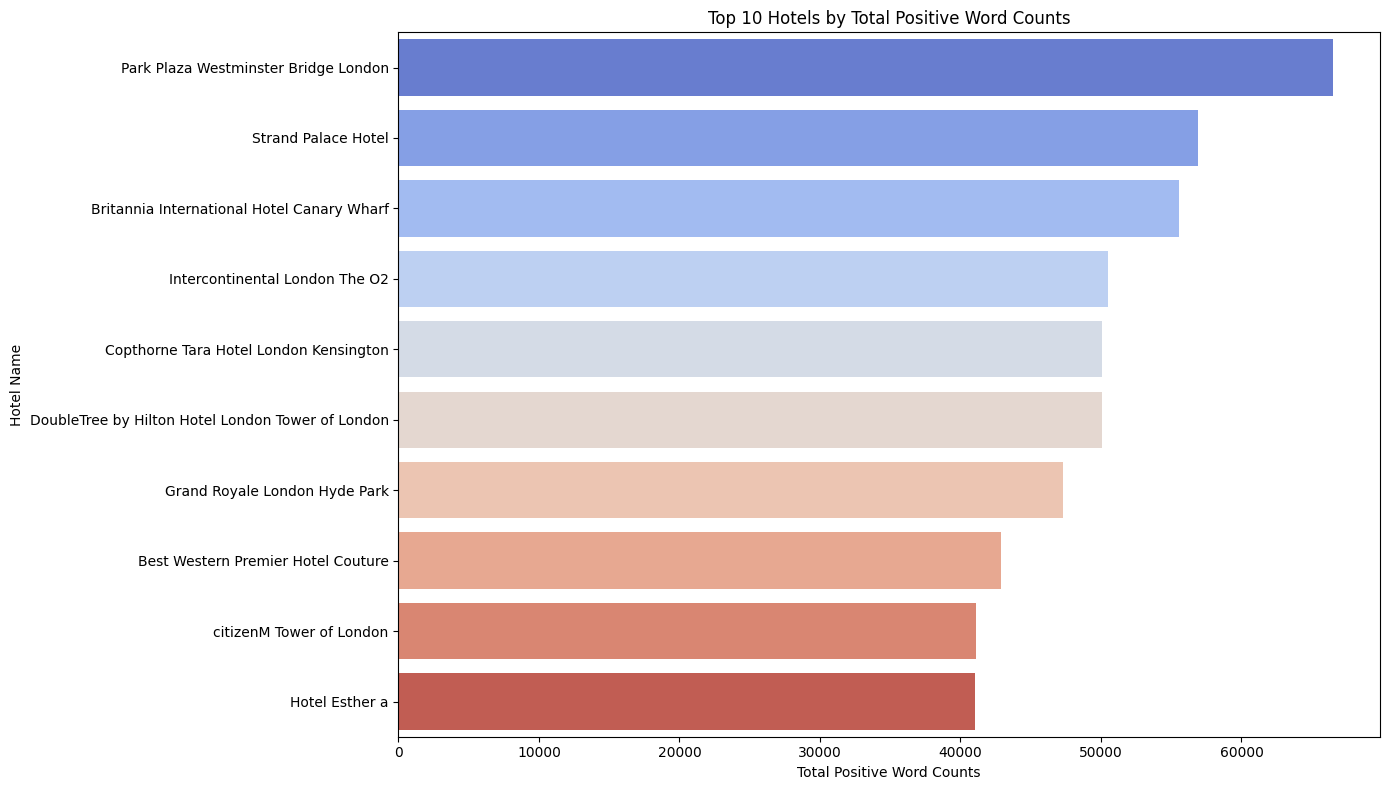

In [ ]:
# Group by hotel name and aggregate negative and positive word counts
word_counts = df.groupby('Hotel_Name').agg({
    'Review_Total_Negative_Word_Counts': 'sum',
    'Review_Total_Positive_Word_Counts': 'sum'
}).reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

# Number of top hotels to display
top_n = 10

# Get top N hotels by negative and positive word counts
top_negative = word_counts.nlargest(top_n, 'Review_Total_Negative_Word_Counts')
top_positive = word_counts.nlargest(top_n, 'Review_Total_Positive_Word_Counts')

# Plot negative word counts
plt.figure(figsize=(14, 8))
sns.barplot(data=top_negative, y='Hotel_Name', x='Review_Total_Negative_Word_Counts', palette='coolwarm')
plt.title(f'Top {top_n} Hotels by Total Negative Word Counts')
plt.xlabel('Total Negative Word Counts')
plt.ylabel('Hotel Name')
plt.tight_layout()
plt.show()

# Plot positive word counts
plt.figure(figsize=(14, 8))
sns.barplot(data=top_positive, y='Hotel_Name', x='Review_Total_Positive_Word_Counts', palette='coolwarm')
plt.title(f'Top {top_n} Hotels by Total Positive Word Counts')
plt.xlabel('Total Positive Word Counts')
plt.ylabel('Hotel Name')
plt.tight_layout()
plt.show()

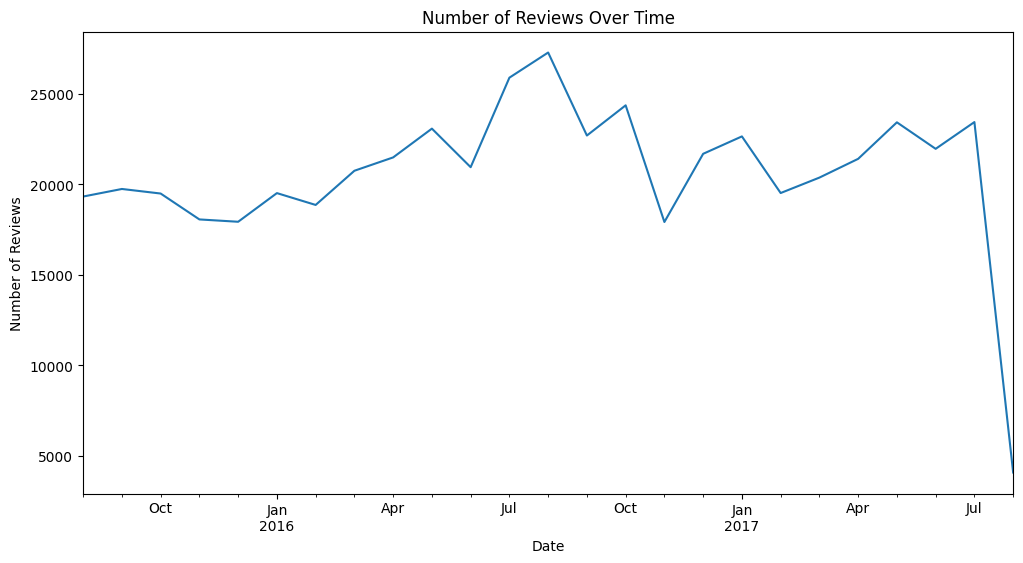

In [ ]:
# Convert Review_Date to datetime
df['Review_Date'] = pd.to_datetime(df['Review_Date'])

# Plot review counts over time
plt.figure(figsize=(12, 6))
df.groupby(df['Review_Date'].dt.to_period('M')).size().plot(kind='line')
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

<ipython-input-61-13b263e02631>:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


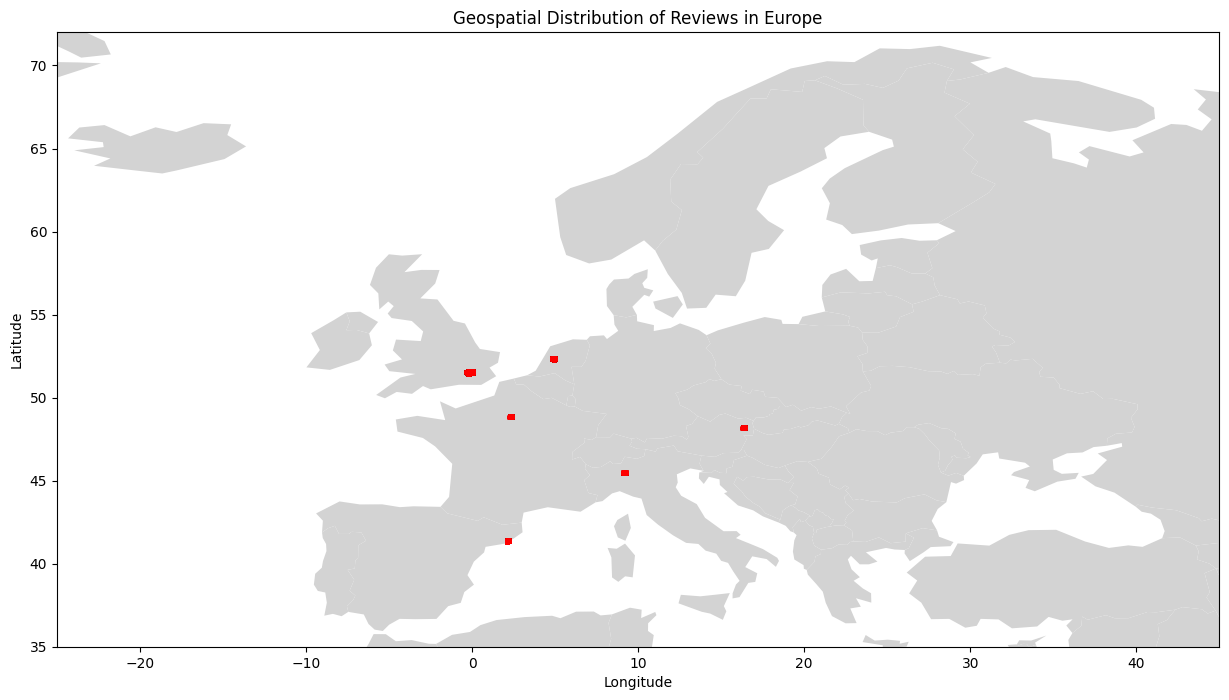

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lng'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Define the bounding box for Europe
min_lon, min_lat = -25, 35
max_lon, max_lat = 45, 72

# Plot geospatial data with a zoomed-in view of Europe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the world map
world.plot(ax=ax, color='lightgrey')

# Plot the geospatial data
geo_df.plot(ax=ax, color='red', markersize=5, alpha=0.5)

# Set the bounds of the plot to zoom in on Europe
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Set the title and labels
plt.title('Geospatial Distribution of Reviews in Europe')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

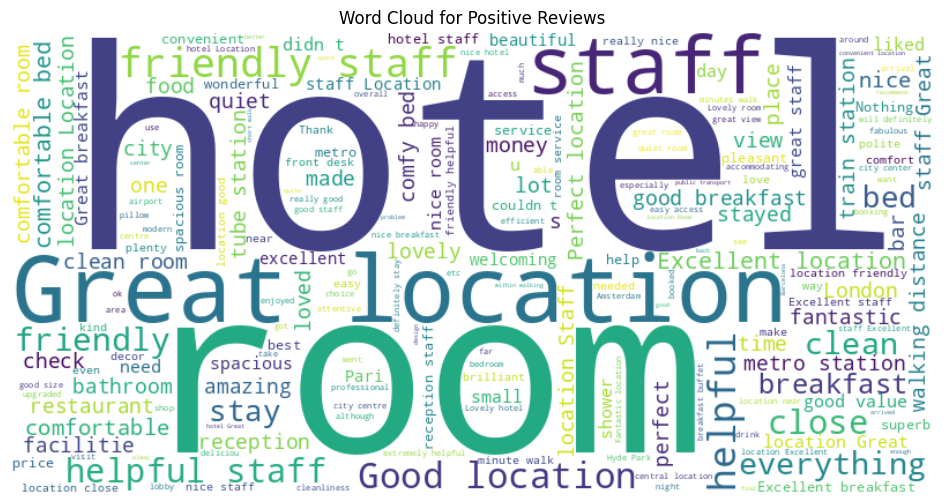

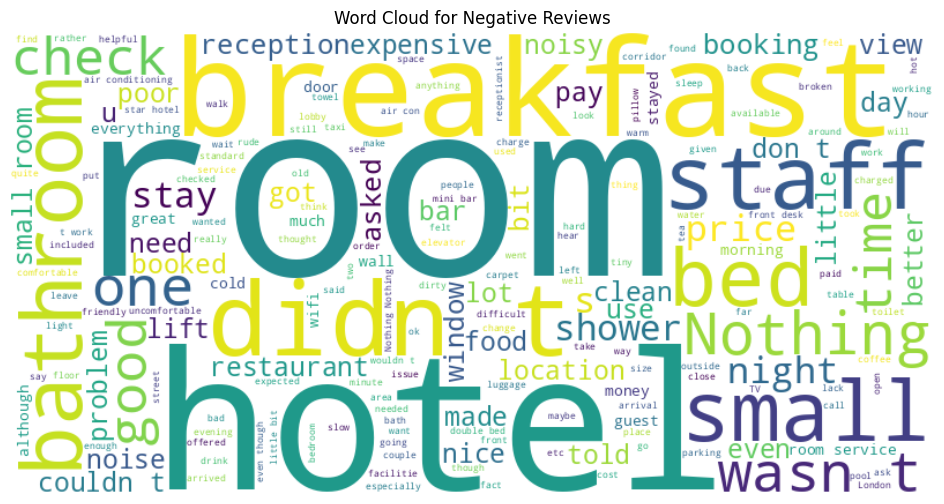

In [ ]:
from wordcloud import WordCloud

# Create a word cloud for positive reviews
text = ' '.join(df['Positive_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Similarly for Negative_Review
text = ' '.join(df['Negative_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

##Data Cleaning

In [ ]:
# Remove "No negative" and "No positive" values
df.loc[:, 'Positive_Review'] = df.Positive_Review.apply(lambda x: x.replace('No Positive', ''))
df.loc[:, 'Negative_Review'] = df.Negative_Review.apply(lambda x: x.replace('No Negative', ''))
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [ ]:
import re
import string
import contractions
from nltk.tokenize import word_tokenize
from nltk import download

# Download NLTK resources
download('punkt')

def expand_contractions(text):
    # Custom contraction mappings
    contractions_dict = {
        "n't": " not",
        "'ll": " will",
        "'ve": " have",
        "'re": " are",
        "'d": " would",
        "'m": " am",
        "'s": " is",
        "'t": " not",
        "'p": " per"
    }

    # Apply the custom contractions dictionary
    for contraction, replacement in contractions_dict.items():
        text = text.replace(contraction, replacement)

    # Use the contractions library for more standard cases
    text = contractions.fix(text)
    return text

def clean_text(text):
    # Expand contractions
    text = expand_contractions(text)

    # Convert to lowercase
    text = text.lower()

    # Replace * with star
    text = text.replace('*', ' star')

    # Replace / with space
    text = text.replace('/', ' ')

    # Replace punctuation with space and ensure proper spacing
    # Replacing each punctuation with space, then normalize spaces
    text = re.sub(r'[^\w\s]', ' ', text)

    # Ensure words are properly separated by single spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Example usage
sample_review = "I didn't like the hotel.It's not good! The coffee/tea was fine. Rating: 4*."
cleaned_review = clean_text(sample_review)
print(cleaned_review)


i did not like the hotel it is not good the coffee tea was fine rating 4 star


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Clean the positive and negative reviews
df['Cleaned_Positive_Review'] = df['Positive_Review'].apply(clean_text)
df['Cleaned_Negative_Review'] = df['Negative_Review'].apply(clean_text)
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Cleaned_Positive_Review,Cleaned_Negative_Review
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,only the park outside of the hotel was beautiful,i am so angry that i made this post available ...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,no real complaints the hotel was great great l...,
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,location was good and staff were ok it is cute...,rooms are nice but for elderly a bit difficult...
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,great location in nice surroundings the bar an...,my room was dirty and i was afraid to walk bar...
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,amazing location and building romantic setting,you when i booked with your company on line yo...


##BART Pipeline

In [ ]:
# Use BART from hugging face summarization to create summarizations for the top 10 most recent reviews for each hotel and create a new .csv file

import pandas as pd
from transformers import pipeline
import re

# Initialize the summarizer
summarizer = pipeline("summarization")

def preprocess_text(text):
    """
    Remove personal pronouns from the text, considering both capitalized and non-capitalized forms.
    """
    # Define a list of pronouns to remove
    pronouns = [
        r'\bI\b', r'\bwe\b', r'\bmy\b', r'\bour\b', r'\bme\b', r'\bus\b',
        r'\bI\'m\b', r'\bwe\'re\b', r'\bmyself\b', r'\bourselves\b',
        r'\bme\b', r'\bours\b', r'\bmine\b', r'\bours\b'
    ]

    for pronoun in pronouns:
        # Remove the pronoun from the text
        text = re.sub(pronoun, '', text, flags=re.IGNORECASE)

    # Remove extra spaces that may have been created after removing pronouns
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Define a function to summarize text with chunking
def summarize_text(text, max_chunk_size=1000, max_length=150, min_length=50):

    # Remove personal pronouns from the text
    text = preprocess_text(text)
    # Tokenize the text into chunks
    chunks = [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]

    # Summarize each chunk
    summaries = [summarizer(chunk, max_length=max_length, min_length=min_length, do_sample=False)[0]['summary_text'] for chunk in chunks]

    # Combine summaries from all chunks
    combined_summary = ' '.join(summaries)

    return combined_summary

# Convert 'Review_Date' to datetime
df['Review_Date'] = pd.to_datetime(df['Review_Date'])

# Group by Hotel Name
hotel_groups = df.groupby('Hotel_Name')

# Initialize a list to store summaries
summaries = []

# Loop through each hotel group
for hotel_name, group in hotel_groups:
    # Sort by 'Review_Date' and select the top 10 most recent reviews
    top_reviews = group.sort_values(by='Review_Date', ascending=False).head(10)

    # Combine the positive and negative reviews
    positive_reviews = ' '.join(top_reviews['Cleaned_Positive_Review'])
    negative_reviews = ' '.join(top_reviews['Cleaned_Negative_Review'])

    # Summarize the combined reviews
    combined_positive_summary = summarize_text(positive_reviews)
    combined_negative_summary = summarize_text(negative_reviews)

    # Combine the summaries into a final summary
    final_summary = (
        f"Hotel: {hotel_name}\n\n"
        f"### Positive Feedback:\n{combined_positive_summary}\n\n"
        f"### Areas for Improvement:\n{combined_negative_summary}\n\n"
    )

    # Append the summary to the list
    summaries.append({'Hotel_Name': hotel_name, 'Summary': final_summary})

# Convert the summaries to a DataFrame
summary_df = pd.DataFrame(summaries)

# Optional: Save the summaries to a CSV file
summary_df.to_csv('hotel_summaries_final.csv', index=False)

# Display the summaries DataFrame
print(summary_df.head())

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 150, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 150, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 150, but your input_length is only 36. Since this is a summarization task, where outputs sho

                           Hotel_Name  \
0                  11 Cadogan Gardens   
1                            1K Hotel   
2  25hours Hotel beim MuseumsQuartier   
3                                  41   
4  45 Park Lane Dorchester Collection   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

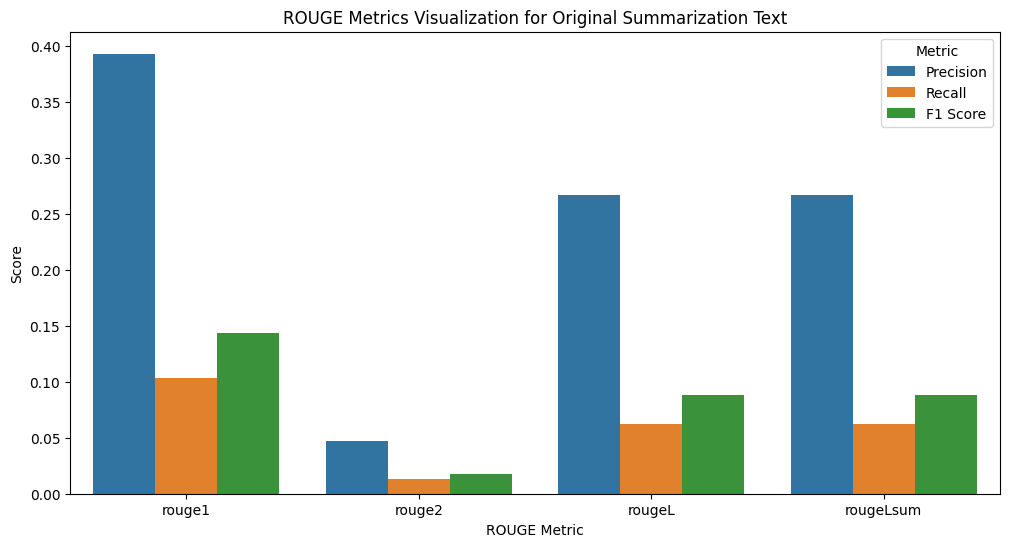

In [ ]:
# Define ROUGE results for original summarization pipeline
original_rouge_results = {
    'rouge1': {'precision': 0.393, 'recall': 0.103, 'fmeasure': 0.144},
    'rouge2': {'precision': 0.047, 'recall': 0.013, 'fmeasure': 0.018},
    'rougeL': {'precision': 0.267, 'recall': 0.062, 'fmeasure': 0.088},
    'rougeLsum': {'precision': 0.267, 'recall': 0.062, 'fmeasure': 0.088}
}

# Convert ROUGE metrics to DataFrame
df_rouge_original = pd.DataFrame(original_rouge_results).T
df_rouge_original.reset_index(inplace=True)
df_rouge_original.columns = ['ROUGE Metric', 'Precision', 'Recall', 'F1 Score']

# Melt the DataFrame for easier plotting
df_rouge_original_melted = df_rouge_original.melt(id_vars='ROUGE Metric', var_name='Metric', value_name='Score')

# Plot the ROUGE metrics
plt.figure(figsize=(12, 6))
sns.barplot(data=df_rouge_original_melted, x='ROUGE Metric', y='Score', hue='Metric')
plt.title('ROUGE Metrics Visualization for Original Summarization Text')
plt.ylabel('Score')
plt.xlabel('ROUGE Metric')
plt.show()

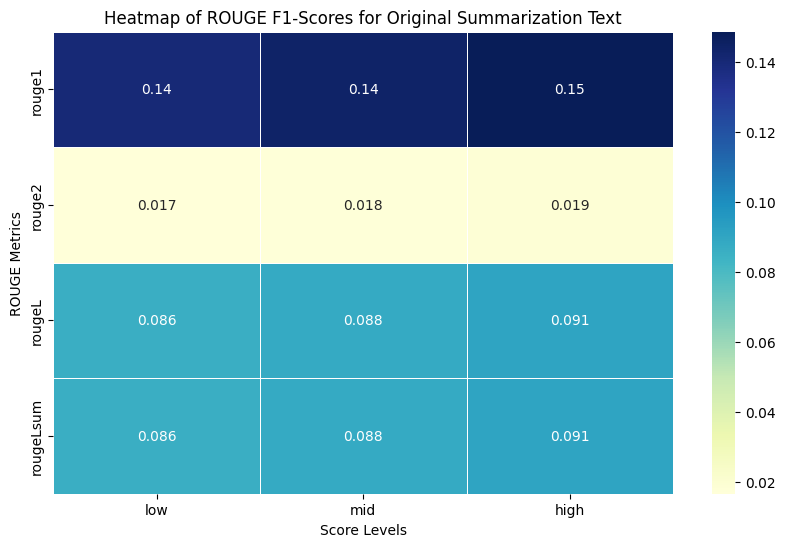

In [ ]:
# ROUGE metrics for original summarization pipeline
original_metrics = {
    'rouge1': {
        'low': 0.14001103849229413,
        'mid': 0.1440964237758385,
        'high': 0.14865844865254435
    },
    'rouge2': {
        'low': 0.016690449860796725,
        'mid': 0.017633807022567928,
        'high': 0.018678039563376353
    },
    'rougeL': {
        'low': 0.08608019472677626,
        'mid': 0.08831289867891247,
        'high': 0.09076537018959847
    },
    'rougeLsum': {
        'low': 0.08615508513739152,
        'mid': 0.08828958499914594,
        'high': 0.09063893371579883
    }
}

# Convert ROUGE metrics to DataFrames
df_original = pd.DataFrame(original_metrics).T

# Plot heatmap for original texts
plt.figure(figsize=(10, 6))
sns.heatmap(df_original, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of ROUGE F1-Scores for Original Summarization Text')
plt.xlabel('Score Levels')
plt.ylabel('ROUGE Metrics')
plt.show()

##Hyperparameter Tuning with T5-Small Model

In [ ]:
# Function to extract the hotel name, positive feedback, and areas for improvement from the summary

def split_summary(row):
    summary = row['Summary']

    # Extract hotel name
    hotel_name = summary.split('\n\n')[0].replace('Hotel: ', '').strip()

    # Extract positive feedback
    positive_feedback = summary.split('### Positive Feedback:')[1].split('### Areas for Improvement:')[0].strip()

    # Extract areas for improvement
    areas_for_improvement = summary.split('### Areas for Improvement:')[1].strip()

    return pd.Series([hotel_name, positive_feedback, areas_for_improvement])

# Apply the function to split the summary into different columns
summary_df[['Hotel_Name', 'Positive_Feedback', 'Areas_for_Improvement']] = summary_df.apply(split_summary, axis=1)

# Optionally, drop the original 'Summary' column if no longer needed
summary_df = summary_df.drop(columns=['Summary'])

# Save the updated DataFrame to a new CSV file
summary_df.to_csv('hotel_summaries_split.csv', index=False)

# Display the updated DataFrame
print(summary_df.head())

                           Hotel_Name  \
0                  11 Cadogan Gardens   
1                            1K Hotel   
2  25hours Hotel beim MuseumsQuartier   
3                                  41   
4  45 Park Lane Dorchester Collection   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Positive_Feedback  \
0                                                                                                    Hotel in a superb location is full of character and class . Staff where excelle

In [ ]:
# Combine the positive and negative reviews to create the Source_Text

# Create a new column 'Source_Text' by combining 'Cleaned_Positive_Review' and 'Cleaned_Negative_Review'
summary_df['Source_Text'] = df.apply(lambda row: row['Cleaned_Positive_Review'] + ' ' + row['Cleaned_Negative_Review'], axis=1)

# Set the Target_Text as the summaries from Positive_Feedback and Areas_for_Improvement
summary_df['Target_Text'] = summary_df.apply(lambda row: 'Positive Feedback: ' + row['Positive_Feedback'] + ' Areas for Improvement: ' + row['Areas_for_Improvement'], axis=1)

# Optionally, drop unnecessary columns if you only need Source_Text and Target_Text
summary_df = summary_df.drop(columns=['Positive_Feedback', 'Areas_for_Improvement'])

# Save the prepared data to a new CSV file
summary_df.to_csv('hotel_summaries_for_finetuning.csv', index=False)

# Display the prepared DataFrame
print(summary_df[['Source_Text', 'Target_Text']].head())

In [ ]:
# Splitting Source and Target data in to 80/20 Train/Test for fine-tuning

# Load your dataset
df_ft = pd.read_csv('hotel_summaries_for_finetuning.csv')

# Prepare the dataset
#df_ft['Source_Text'] = df['Cleaned_Positive_Review'] + ' ' + df['Cleaned_Negative_Review']

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df_ft[['Source_Text', 'Target_Text']])

# Split into training and test sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset_dict = DatasetDict({
    'train': dataset['train'],
    'test': dataset['test']
})

print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['Source_Text', 'Target_Text'],
        num_rows: 1193
    })
    test: Dataset({
        features: ['Source_Text', 'Target_Text'],
        num_rows: 299
    })
})


In [ ]:
# Create a function to evaluate metrics using ROUGE, setting up hyperparameters for fine-tuning, train the model and evaluate the results

# Initialize the ROUGE metric
rouge_metric = load_metric("rouge")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = tokenizer.batch_decode(logits, skip_special_tokens=True)
    references = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return rouge_metric.compute(predictions=predictions, references=references)

# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

# Tokenize the dataset
def tokenize_function(examples):
    # Tokenize and pad/truncate to model's max length
    inputs = tokenizer(examples['Source_Text'], padding='max_length', truncation=True, max_length=512)
    labels = tokenizer(examples['Target_Text'], padding='max_length', truncation=True, max_length=512)

    inputs['labels'] = labels['input_ids']

    return inputs

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

# Fine-tuning arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="output",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,  # Small batch size
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)

# Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Create the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start training
trainer.train()

# Evaluate the model on the test set after training
test_results = trainer.evaluate(eval_dataset=tokenized_datasets['test'])
print(test_results)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/1193 [00:00<?, ? examples/s]

Map:   0%|          | 0/299 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch,Training Loss,Validation Loss
0,No log,1.911718
1,No log,1.614239
2,No log,1.568853


{'eval_loss': 1.5688529014587402, 'eval_runtime': 3.9635, 'eval_samples_per_second': 75.438, 'eval_steps_per_second': 37.845, 'epoch': 2.9949748743718594}



ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics commonly used to evaluate the quality of summaries generated by models in natural language processing tasks, especially for summarization. ROUGE measures the overlap between the model-generated summary and a reference (human-written) summary. Here’s a breakdown of the most commonly used ROUGE metrics and how to interpret them:

1. ROUGE-N
ROUGE-1: Measures the overlap of unigrams (single words) between the generated summary and the reference summary.
ROUGE-2: Measures the overlap of bigrams (two consecutive words) between the generated summary and the reference summary.
ROUGE-N (where N can be 1, 2, 3, etc.): Measures the overlap of N-grams between the generated and reference summaries.
Interpretation:

ROUGE-1 is useful for measuring the basic content overlap, focusing on the presence of individual words.
ROUGE-2 provides more insight into the fluency and coherence of the summary, as it considers pairs of words.
Higher scores indicate better performance, with more overlap between the generated and reference summaries.
2. ROUGE-L (Longest Common Subsequence)
ROUGE-L measures the longest common subsequence (LCS) between the generated summary and the reference summary.
Interpretation:

ROUGE-L focuses on capturing the longest sequence of words that appear in both the generated summary and the reference summary in the same order.
It is more sensitive to the order of words and thus better reflects the structure of the summary.
3. ROUGE-S (Skip-Bigram)
ROUGE-S measures the overlap of skip-bigrams (pairs of words in their order of appearance, allowing gaps in between) between the generated and reference summaries.
Interpretation:

ROUGE-S is more flexible in handling word order compared to ROUGE-N and ROUGE-L. It evaluates whether key phrases or word pairs appear in both summaries, even if other words separate them.
4. Precision, Recall, and F1-Score in ROUGE
Precision: Measures how many of the words/phrases in the generated summary are also present in the reference summary. It focuses on the accuracy of the generated summary.
Recall: Measures how many of the words/phrases in the reference summary are also present in the generated summary. It focuses on the completeness of the generated summary.
F1-Score: The harmonic mean of precision and recall, providing a balanced measure of both.
Interpretation:

High Precision: The generated summary is concise and accurate but may miss some information (might be too short).
High Recall: The generated summary includes most of the important information but may include unnecessary details (might be too long).
High F1-Score: Indicates a good balance between precision and recall, meaning the summary is both accurate and complete.
Example of ROUGE Metric Interpretation:
ROUGE-1 (Precision/Recall/F1): 0.45 / 0.50 / 0.47

Interpretation: The model captures about 45% of the words from the reference summary accurately (precision), 50% of the reference words are present in the generated summary (recall), and overall, there's a balanced performance with an F1-Score of 0.47.
ROUGE-2 (Precision/Recall/F1): 0.30 / 0.35 / 0.32

Interpretation: The model captures about 30% of bigrams correctly, and 35% of the bigrams in the reference are present in the generated summary, with an overall F1 of 0.32.
ROUGE-L (Precision/Recall/F1): 0.40 / 0.45 / 0.42

Interpretation: The longest common subsequence overlap is decent, showing that the summary maintains some structure of the reference summary.

In [ ]:
# Rouge metrics for t5-small model

# Initialize ROUGE metric
rouge_metric = load_metric("rouge")

# Generate predictions on the test set
predictions = trainer.predict(tokenized_datasets['test'])

# Decode predictions and labels
decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

# Compute ROUGE scores
rouge_results = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

# Print ROUGE results
print(rouge_results)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': AggregateScore(low=Score(precision=0.17289737585208761, recall=0.018659567831340363, fmeasure=0.033491396709474104), mid=Score(precision=0.2024503894789393, recall=0.022181840892067164, fmeasure=0.039635745172167815), high=Score(precision=0.23557076995213144, recall=0.02602030734589377, fmeasure=0.046375189750454446)), 'rouge2': AggregateScore(low=Score(precision=0.039860924175121, recall=0.004103230388269686, fmeasure=0.007411312165324088), mid=Score(precision=0.052612174450901564, recall=0.00534110458688422, fmeasure=0.009643675880251468), high=Score(precision=0.06733582385055432, recall=0.006771925221975717, fmeasure=0.01216216208588528)), 'rougeL': AggregateScore(low=Score(precision=0.13559723448880223, recall=0.014379381318924668, fmeasure=0.025806190755008694), mid=Score(precision=0.1612365018600458, recall=0.01732555019767275, fmeasure=0.03104838626800905), high=Score(precision=0.18655350669964982, recall=0.020212835605562453, fmeasure=0.03611302056914198)), 'rougeLsu

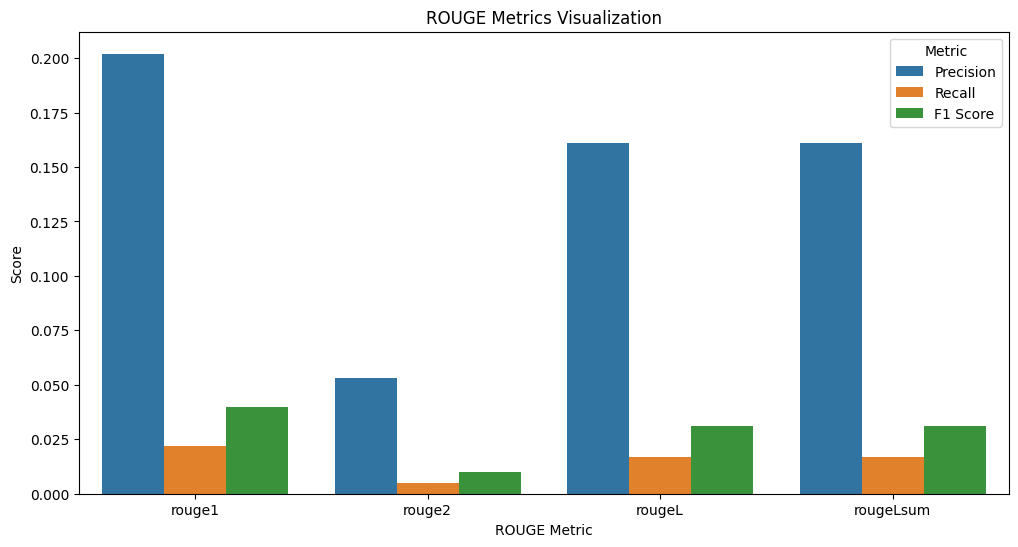

In [ ]:
# Rouge metrics for t5-small model and visualization

# ROUGE metrics
rouge_metrics = {
    'rouge1': {'precision': 0.202, 'recall': 0.022, 'fmeasure': 0.040},
    'rouge2': {'precision': 0.053, 'recall': 0.005, 'fmeasure': 0.010},
    'rougeL': {'precision': 0.161, 'recall': 0.017, 'fmeasure': 0.031},
    'rougeLsum': {'precision': 0.161, 'recall': 0.017, 'fmeasure': 0.031}
}

# Convert ROUGE metrics to DataFrame
df_rouge = pd.DataFrame(rouge_metrics).T
df_rouge.reset_index(inplace=True)
df_rouge.columns = ['ROUGE Metric', 'Precision', 'Recall', 'F1 Score']

# Melt the DataFrame for easier plotting
df_rouge_melted = df_rouge.melt(id_vars='ROUGE Metric', var_name='Metric', value_name='Score')

# Plot the ROUGE metrics
plt.figure(figsize=(12, 6))
sns.barplot(data=df_rouge_melted, x='ROUGE Metric', y='Score', hue='Metric')
plt.title('ROUGE Metrics Visualization')
plt.ylabel('Score')
plt.xlabel('ROUGE Metric')
plt.show()

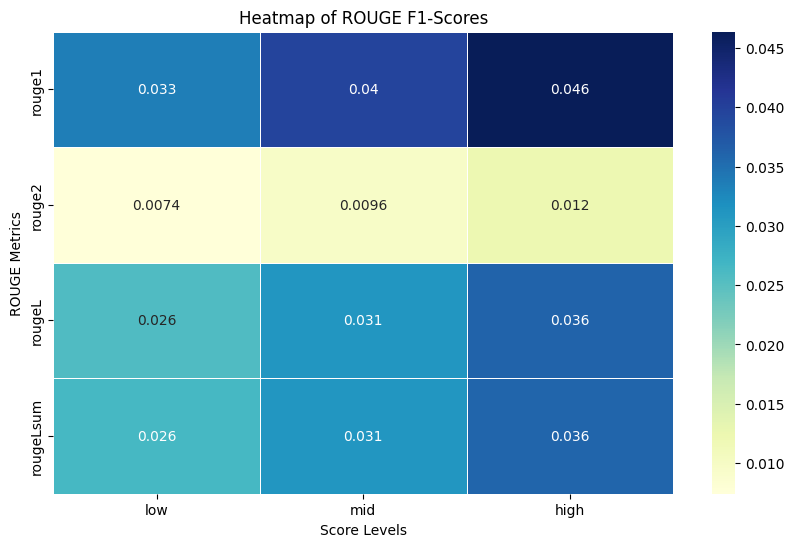

In [ ]:
# Heatmap for t5-small model F1 scores

# ROUGE metrics provided
metrics = {
    'rouge1': {
        'low': 0.033491396709474104,
        'mid': 0.039635745172167815,
        'high': 0.046375189750454446
    },
    'rouge2': {
        'low': 0.007411312165324088,
        'mid': 0.009643675880251468,
        'high': 0.01216216208588528
    },
    'rougeL': {
        'low': 0.025806190755008694,
        'mid': 0.03104838626800905,
        'high': 0.03611302056914198
    },
    'rougeLsum': {
        'low': 0.026450945190316315,
        'mid': 0.03105709368234234,
        'high': 0.03602134273714703
    }
}

# Convert to DataFrame
df_heatmap = pd.DataFrame(metrics).T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of ROUGE F1-Scores')
plt.xlabel('Score Levels')
plt.ylabel('ROUGE Metrics')
plt.show()

ROUGE results for original texts:
{'rouge1': AggregateScore(low=Score(precision=0.3855750279505138, recall=0.0995175912133755, fmeasure=0.14001103849229413), mid=Score(precision=0.39321294808034685, recall=0.10329752320963635, fmeasure=0.1440964237758385), high=Score(precision=0.4001772715471113, recall=0.10796578753671775, fmeasure=0.14865844865254435)), 'rouge2': AggregateScore(low=Score(precision=0.04418395236801689, recall=0.011827967378280683, fmeasure=0.016690449860796725), mid=Score(precision=0.04673814219493364, recall=0.012597987339394209, fmeasure=0.017633807022567928), high=Score(precision=0.04983859698691583, recall=0.013419500621680786, fmeasure=0.018678039563376353)), 'rougeL': AggregateScore(low=Score(precision=0.2611264467208688, recall=0.05949510774606186, fmeasure=0.08608019472677626), mid=Score(precision=0.2672475659981853, recall=0.06161122609906435, fmeasure=0.08831289867891247), high=Score(precision=0.27379306677280624, recall=0.06403938548428706, fmeasure=0.09076

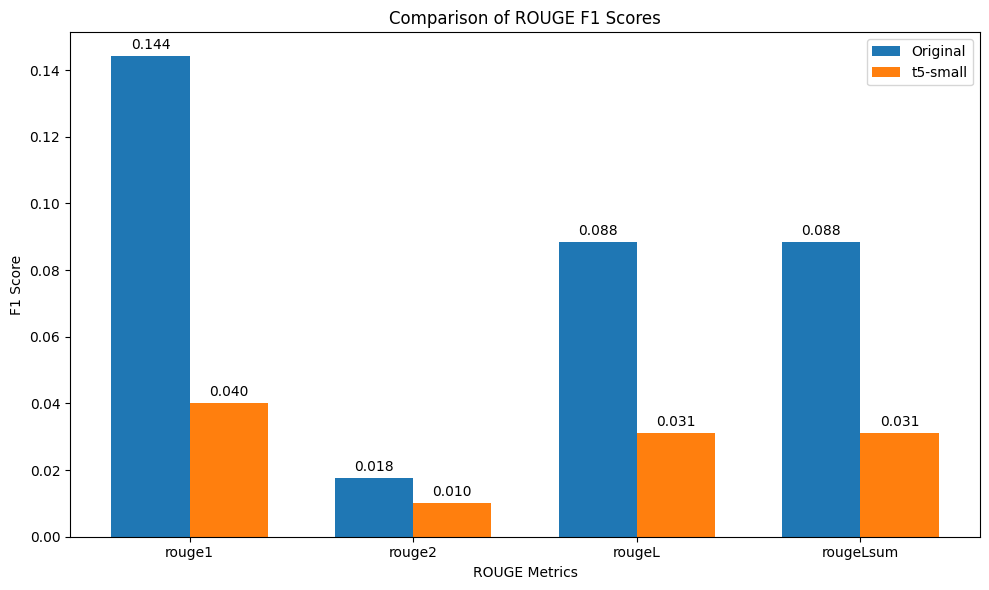

In [ ]:
# Comparison of Original Summarization Model and t5-Small Model

# Initialize the ROUGE metric
rouge_metric = load_metric("rouge")

def compute_rouge_for_originals(df):
    # Prepare the predictions and references
    references = df_ft['Target_Text'].tolist()
    predictions = df_ft['Source_Text'].tolist()  # Assuming you want to compare the source text directly with target text

    # Compute ROUGE scores
    rouge_results = rouge_metric.compute(predictions=predictions, references=references)
    return rouge_results

# Compute ROUGE for original texts
original_rouge_results = compute_rouge_for_originals(df)
print("ROUGE results for original texts:")
print(original_rouge_results)

def extract_rouge_scores(rouge_results):
    # Extract F1-scores from ROUGE results
    scores = {key: val.mid.fmeasure for key, val in rouge_results.items()}
    return scores

# Extract ROUGE scores for original texts
original_scores = extract_rouge_scores(original_rouge_results)

rouge_metrics = {
    'rouge1': {'precision': 0.202, 'recall': 0.022, 'fmeasure': 0.040},
    'rouge2': {'precision': 0.053, 'recall': 0.005, 'fmeasure': 0.010},
    'rougeL': {'precision': 0.161, 'recall': 0.017, 'fmeasure': 0.031},
    'rougeLsum': {'precision': 0.161, 'recall': 0.017, 'fmeasure': 0.031}
}

# Extract F1-scores for comparison
original_f1_scores = {key: original_scores.get(key, 0) for key in rouge_metrics.keys()}
defined_f1_scores = {key: value['fmeasure'] for key, value in rouge_metrics.items()}

# Plot comparison
labels = original_f1_scores.keys()
original_values = [original_f1_scores[label] for label in labels]
defined_values = [defined_f1_scores[label] for label in labels]

x = np.arange(len(labels))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_values, width, label='Original')
bars2 = ax.bar(x + width/2, defined_values, width, label='t5-small')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('ROUGE Metrics')
ax.set_ylabel('F1 Score')
ax.set_title('Comparison of ROUGE F1 Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Label with value
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()